The objective of this mini-project is to define and train a Conditional VAE
(CVAE), by following the instructions below:

## Find resources that explain what a CVAE is, it’s difference with VAEs, the loss functions used to train it etc.


https://medium.com/@sofeikov/implementing-variational-autoencoders-from-scratch-533782d8eb95

https://medium.com/@sofeikov/implementing-conditional-variational-auto-encoders-cvae-from-scratch-29fcbb8cb08f

https://theaiacademy.blogspot.com/2020/05/understanding-conditional-variational.html

**À expliquer** 

Problème du VAE : 1) impossibilité de générer un nouvel échantillon (image+label) en imposant des conditions spécifiques (par exemple, générer une image à partir du label)
Ce qu'il faudrait expliquer : prior distribution, ce qu'est un encodeur/décodeur, AE et VAE

Différence avec VAE : Pour générer une nouvelle observation x, la VAE, on sélectionne un z à partir de la distribution a priori et on retrouve le label de x en calculant P(x sachant z). Avec la CVAE, on selectionne un (z sachant y) ie on choisit le label du x qu'on veut générer, et ensuite, on génére (x sachant y et z)

Choix de la loss function (voir cours VAE slide 35)

https://github.com/nnormandin/Conditional_VAE/blob/master/Conditional_VAE.ipynb


**Fin**



## Train a CVAE on the Fashion-MNIST dataset (available to download from torchvision).

Explain and argue the different choices you make along the way, in particular:
– The choice of the architecture, the layer types, the layer sizes and the
activations.
– The choice of the different hyper-parameters: batch size, learning rate,
number of epochs, regularization weight...
– The choice of the loss function, the different terms in it, and their
individual purposes.


Include links to articles, blog posts, videos... that helped you decide on the above choices.


Include the code of the different trials/experiments that helped you decide on the above choices.




In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np

import torch
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda


In [3]:
from torchvision import datasets, transforms
batch_size = 128

# Data loading
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='../../data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='../../data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


100%|█████████████████████████| 26421880/26421880 [00:00<00:00, 28527629.64it/s]


Extracting ../../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../../data/FashionMNIST/raw



100%|████████████████████████████████| 29515/29515 [00:00<00:00, 1424222.94it/s]

Extracting ../../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../../data/FashionMNIST/raw



100%|███████████████████████████| 4422102/4422102 [00:00<00:00, 18283372.24it/s]


Extracting ../../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/FashionMNIST/raw



100%|█████████████████████████████████| 5148/5148 [00:00<00:00, 31068024.45it/s]

Extracting ../../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/FashionMNIST/raw



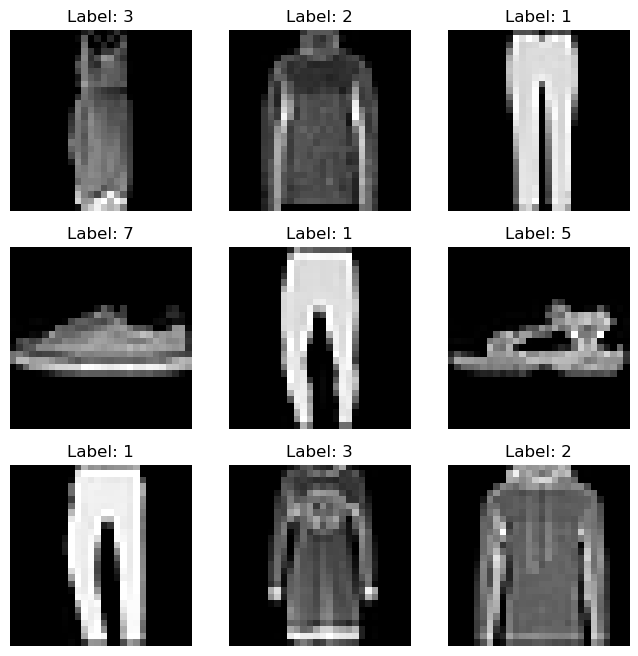

[0 1 2 3 4 5 6 7 8 9]


In [9]:
# Plot 9 random images from the MNIST train dataset
def plot_images(img_dataset):
    """Plots 9 random images from the given dataset

    Args:
        img_dataset (torch.utils.data.Dataset): The dataset to plot images from
    """

    # Set up a 3x3 grid for plotting 9 random images
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    
    # Plot 9 random images from the img_dataset
    for i in range(1, cols * rows + 1):
        random_idx = torch.randint(len(img_dataset), size=(1,)).item()  # Pick a random index
        img, label = img_dataset[random_idx]  # Get the image and its label
        figure.add_subplot(rows, cols, i)  # Add subplot
        plt.title(f'Label: {label}')  # Set title to show the label
        plt.axis("off")  # Turn off axis
        plt.imshow(img.squeeze(), cmap="gray")  # Plot image
    
    plt.show()  # Display the figure

plot_images(train_dataset)
print(np.unique(train_dataset.targets[:]))

In [ ]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=10):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 14, 14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim) 
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)  #pour forcer à avor des valeurs positives, on prend le log de var et non pas var
        self.fc_decode = nn.Linear(latent_dim, 128 * 4 * 4) 
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # Output: (1, 28, 28)
            nn.Sigmoid()
        )

    #TO DO (concatenation de x et y)
    def encode(self, x):
        x = self.encoder(x)
        x = x.view(-1, 128 * 4 * 4) # Flatten the output of the convolutional layers
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
        
     #TO DO (concatenation de z et y)
    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(-1, 128, 4, 4)  # Reshape to (128, 4, 4) for the decoder
        x = self.decoder(x)
        return x
        
    #TO DO (ajout de y en argument)
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.sample(mu, logvar)
        return self.decode(z), mu, logvar

## Generate 5 new samples for each class of the Fashion-MNIST dataset using the CVAE.


## Plot different visualizations for the results: the curves of the different terms in the loss functions, the learnt latent space...